In [1]:
# Add root directory to path
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.path.abspath('..'),
                  os.pardir)
)
sys.path.append(PROJECT_ROOT)

# Imports
from electronTransportCode.SimOptions import PointSourceSimulation
from electronTransportCode.SimulationDomain import SimulationDomain
from electronTransportCode.MCParticleTracer import AnalogParticleTracer
from electronTransportCode.MCEstimator import FluenceEstimator, DoseEstimator, TrackEndEstimator
from electronTransportCode.ParticleModel import PointSourceParticle
from electronTransportCode.Material import unitDensityMaterial
# %matplotlib widget

### Set up all objects
Either do simulation, or load objects from data file

In [2]:
SEED: int = 4  # Random number generator seed
SIM: bool = False

if SIM:
    NB_PARTICLES = 10000
    
    # Set up initial conditions
    eSource: float = 1.0

    # Set up simulation domain
    xmin = -1.0; xmax = 1.0; xbins = 100
    ymin = -1.5; ymax = 1.5; ybins = 100
    simDomain = SimulationDomain(xmin, xmax, ymin, ymax, xbins, ybins, material=unitDensityMaterial)
    pointSourceSim = PointSourceSimulation(minEnergy=0.0, rngSeed=SEED, eSource=eSource, simDomain=simDomain)

    # Set up dose estimator
    Ebins = 100
    fluenceEstimator = FluenceEstimator(simDomain=simDomain, Emin=0.0, Emax=eSource, Ebins=Ebins)
    doseEstimator = DoseEstimator(simDomain)
    trackEndEstimator = TrackEndEstimator(simDomain, NB_PARTICLES)

    # Set up particle
    particle = PointSourceParticle(generator=SEED)  # rng is later overridden by simulation object 

    # Set up particle tracer
    particleTracer = AnalogParticleTracer(particle=particle, simOptions=pointSourceSim, simDomain=simDomain)
    
    
    particleTracer(nbParticles=NB_PARTICLES, estimators=(fluenceEstimator, doseEstimator, trackEndEstimator))
    print(f'Average amount of events: {particleTracer.averageNbCollisions}')
else:
    with open('data/particleTracer.pkl', 'rb') as file:
        particleTracer = pickle.load(file)
        
    with open('data/fluenceEstimator.pkl', 'rb') as file:
        fluenceEstimator = pickle.load(file)
        
    with open('data/doseEstimator.pkl', 'rb') as file:
        doseEstimator = pickle.load(file)
        
    with open('data/trackEndEstimator.pkl', 'rb') as file:
        trackEndEstimator = pickle.load(file)

    particle = particleTracer.particle
    simDomain = particleTracer.simDomain
    pointSourceSim = particleTracer.simOptions

    eSource= pointSourceSim.eSource
    xmin = simDomain.xmin
    xmax = simDomain.xmax
    ymin = simDomain.ymin
    ymax = simDomain.ymax
    xbins = simDomain.xbins
    ybins = simDomain.ybins
    Ebins = fluenceEstimator.Ebins

In [3]:
# Compute exact solution at E = 0 (t = 1)
import exactSolution
solRes = 201
xSolIndex = int((solRes-1)/2)
solxmax = 1.0; solxmin = -1.0
xs = np.linspace(solxmin, solxmax, solRes)
ys = np.linspace(solxmin, solxmax, solRes)
xv, _ = np.meshgrid(xs, ys)
res = np.zeros_like(xv)
for i1, x1 in enumerate(xs):
    for i2, y1 in enumerate(ys):
        if np.power(x1, 2) + np.power(y1, 2) <= 1.0:
            # r = np.power(x1, 2) + np.power(y1, 2)
            # t = 1.0
            # res[i1, i2] = 1/(2*np.pi*t*np.sqrt(np.power(t, 2) - np.power(r, 2)))
            res[i1, i2] = exactSolution.pointSourceSolution(x1, y1, 0.0, eSource)


/home/r0738465/Documents/electronTransportCode/numericalExperiments/pointSource/exactSolution.py:42: RuntimeWarning: invalid value encountered in double_scalars
  term1 = np.exp(-t)*np.log((1.0 + gamma)/(1.0 - gamma))*C/(4*np.pi*R*t)
/home/r0738465/Documents/electronTransportCode/numericalExperiments/pointSource/exactSolution.py:53: RuntimeWarning: invalid value encountered in double_scalars
  return np.exp(-t)*np.power(C, 2)*(1 - np.power(gamma, 2))*i1*np.heaviside(1-gamma, HEAVISIDE_THRESHOLD)/(np.power(np.pi, 2)*32*R)


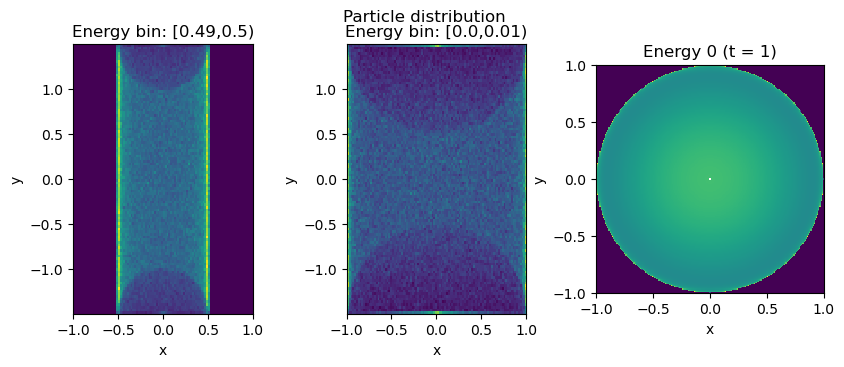

In [4]:
# Plot energy deposition
ebin2Index = 0
ebin1Index = int((Ebins-1)/2)
finalFluence = np.flipud(np.reshape(fluenceEstimator.scoreMatrix[ebin2Index, :], (xbins, xbins)))
initFluence = np.flipud(np.reshape(fluenceEstimator.scoreMatrix[ebin1Index, :], (xbins, xbins)))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3.5))
fig.suptitle('Particle distribution')

roundDigits = 3
# Initial particle distribution
bin1left = np.round(fluenceEstimator.Erange[ebin1Index], roundDigits)
bin1right = np.round(fluenceEstimator.Erange[ebin1Index+1], roundDigits)
ax1.set_title(f'Energy bin: [{bin1left},{bin1right})')
ax1.matshow(initFluence, extent=[xmin, xmax, ymin, ymax])
ax1.set_xticks(np.linspace(xmin, xmax, 5))
ax1.set_yticks(np.linspace(xmin, xmax, 5))
ax1.xaxis.tick_bottom()
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# End particle distribution
bin2left = np.round(fluenceEstimator.Erange[ebin2Index], roundDigits)
bin2right = np.round(fluenceEstimator.Erange[ebin2Index+1], roundDigits)
ax2.matshow(finalFluence, extent=[xmin, xmax, ymin, ymax])
ax2.set_title(f'Energy bin: [{bin2left},{bin2right})')
ax2.set_xticks(np.linspace(xmin, xmax, 5))
ax2.set_yticks(np.linspace(xmin, xmax, 5))
ax2.xaxis.tick_bottom()
ax2.set_xlabel('x')
ax2.set_ylabel('y')

# Exact end particle distribution
ax3.matshow(res, extent=[solxmin, solxmax, solxmin, solxmax])
ax3.set_title(f'Energy 0 (t = 1)')
ax3.set_xticks(np.linspace(solxmin, solxmax, 5))
ax3.set_yticks(np.linspace(solxmin, solxmax, 5))
ax3.xaxis.tick_bottom()
ax3.set_xlabel('x')
ax3.set_ylabel('y')

plt.show()

0.999572
0.00042799999999999447


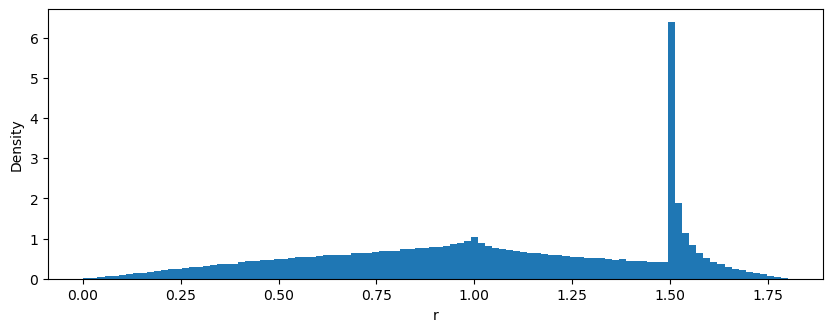

In [5]:
# Radial Particle distribution at t = 1.0 
fig, ax1 = plt.subplots(figsize=(10, 3.5))
radialDensity = trackEndEstimator.scoreMatrix
binVal, binEdge, _ = ax1.hist(radialDensity, bins=100, density=True)
ax1.set_xlabel('r')
ax1.set_ylabel('Density')

print(binVal[0:-1].sum()/binVal.sum())
print(binVal[-1].sum()/binVal.sum())

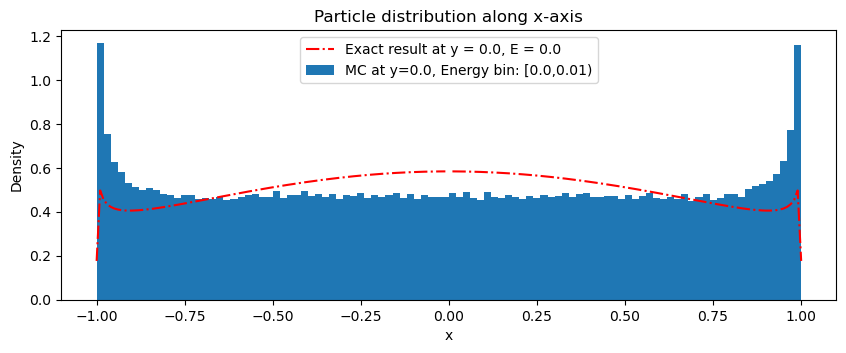

In [6]:
 # End particle distribution along x-axis
ybin1Index = int((ybins)/2)

ybin1down = np.round(simDomain.yrange[ybin1Index], roundDigits)
ybin1up = np.round(simDomain.yrange[ybin1Index+1], roundDigits)

xFinalFluence = finalFluence[30:70, :].sum(axis=0)  # finalFluence.sum(axis=0) 
fig, ax1 = plt.subplots(figsize=(10, 3.5))
ax1.set_title('Particle distribution along x-axis')

dxMC = simDomain.xrange[1]-simDomain.xrange[0]
dxRes = xs[1] - xs[0]

normMC = (xFinalFluence.sum()*dxMC)
normRes = np.trapz(np.nan_to_num(res[xSolIndex]), dx=dxRes)

ax1.bar(simDomain.xrange[:-1], xFinalFluence/normMC, align='edge', width=dxMC, 
        label=f'MC at y={np.round(simDomain.xrange[ybin1Index], roundDigits)}, Energy bin: [{bin2left},{bin2right})')
ax1.plot(xs, res[xSolIndex]/normRes, '-.r', label=f'Exact result at y = {np.round(xs[xSolIndex], roundDigits)}, E = 0.0')
ax1.set_xlabel('x')
ax1.set_ylabel('Density')
ax1.legend()

Two sampling strategies for the angle

(array([505., 526., 483., 497., 494., 491., 520., 467., 493., 489., 527.,
        491., 479., 478., 498., 493., 510., 532., 505., 522.]),
 array([-9.99990922e-01, -8.99993332e-01, -7.99995743e-01, -6.99998153e-01,
        -6.00000564e-01, -5.00002974e-01, -4.00005384e-01, -3.00007795e-01,
        -2.00010205e-01, -1.00012616e-01, -1.50261659e-05,  9.99825634e-02,
         1.99980153e-01,  2.99977743e-01,  3.99975332e-01,  4.99972922e-01,
         5.99970511e-01,  6.99968101e-01,  7.99965690e-01,  8.99963280e-01,
         9.99960869e-01]),
 <BarContainer object of 20 artists>)

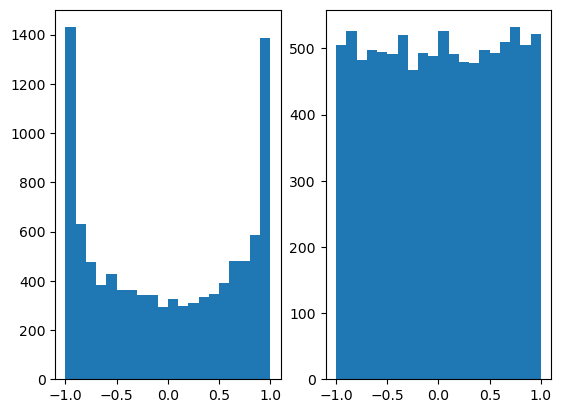

In [10]:
Nbsamples = 10000

# sample strategy 1
rs = np.random.uniform(size = Nbsamples)
theta = 2*np.arcsin(np.sqrt(rs))
mu1 = np.cos(np.random.uniform(low=0.0, high=2*np.pi, size = Nbsamples))

# sample strategy 2
mu2 = np.random.uniform(low=-1, high=1, size = Nbsamples)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(mu1, bins = 20)
ax2.hist(mu2, bins = 20)

### TEMP

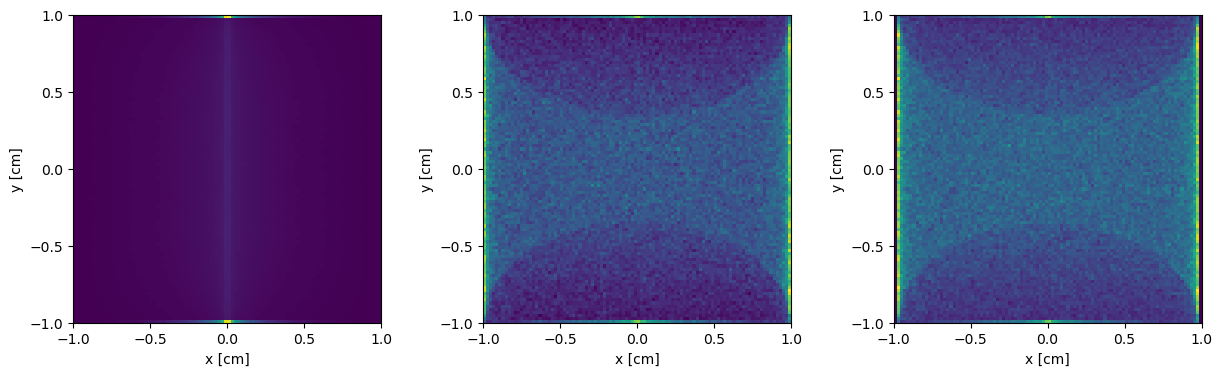

450523.2747499534

In [8]:
# Debugging
# Compute dose with dose estimator
# print(fluenceEstimator.scoreMatrix.sum())
# print(doseEstimator.scoreMatrix.sum())
temp1 = fluenceEstimator.scoreMatrix.sum(axis=0)
temp2 = doseEstimator.scoreMatrix
np.where(temp1 != temp2)

# Plot energy deposition
energyDeposition = np.reshape(doseEstimator.scoreMatrix, (simDomain.ybins, simDomain.xbins))
fluence1 = np.reshape(fluenceEstimator.scoreMatrix[0], (simDomain.ybins, simDomain.xbins))
fluence2 = np.reshape(fluenceEstimator.scoreMatrix[2], (simDomain.ybins, simDomain.xbins))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
ax1.matshow(energyDeposition, extent=[xmin, xmax, xmin, xmax], origin='lower')
ax1.set_xticks(np.linspace(xmin, xmax, 5))
ax1.set_yticks(np.linspace(xmin, xmax, 5))
ax1.xaxis.tick_bottom()
ax1.set_xlabel('x [cm]')
ax1.set_ylabel('y [cm]')

ax2.matshow(fluence1, extent=[xmin, xmax, xmin, xmax], origin='lower')
ax2.set_xticks(np.linspace(xmin, xmax, 5))
ax2.set_yticks(np.linspace(xmin, xmax, 5))
ax2.xaxis.tick_bottom()
ax2.set_xlabel('x [cm]')
ax2.set_ylabel('y [cm]')

ax3.matshow(fluence2, extent=[xmin, xmax, xmin, xmax], origin='lower')
ax3.set_xticks(np.linspace(xmin, xmax, 5))
ax3.set_yticks(np.linspace(xmin, xmax, 5))
ax3.xaxis.tick_bottom()
ax3.set_xlabel('x [cm]')
ax3.set_ylabel('y [cm]')

plt.show()

fluenceEstimator.scoreMatrix.sum()

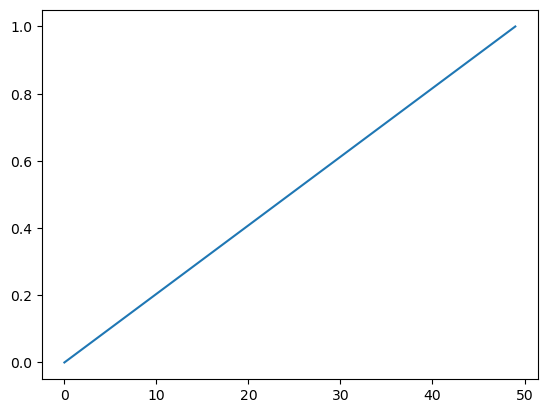

In [9]:
fig, ax = plt.subplots()
ax.plot(np.linspace(0, 1))